
1. Load the colliders data
2. Discretize your search space into a grid or graph
3. Define a start and goal location
4. Find a coarse 2D plan from start to goal
5. Choose a location along that plan and discretize
   a local volume around that location (for example, you
   might try a 40x40 m area that is 10 m high discretized
   into 1m^3 voxels)
6. Define your goal in the local volume to a a node or voxel
   at the edge of the volume in the direction of the next
   waypoint in your coarse global plan.
7. Plan a path through your 3D grid or graph to that node
   or voxel at the edge of the local volume.  

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Utils
from planning_utils import create_grid, a_star, closest_point, heuristic
from udacidrone.frame_utils import global_to_local, local_to_global
from sampler import Sampler
from graph import create_graph, a_star_graph

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

In [3]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [4]:
with open('colliders.csv', 'r') as f:
    temp = f.readline()
    temp = temp.replace('lat0 ', '').replace('lon0', '')
    lat, lon = temp.split(', ')
    lat, lon = float(lat), float(lon)

    print(lon)

-122.39745


In [27]:
# Static drone altitude (meters)
drone_altitude = 1
safety_distance = 2

grid, north, east = create_grid(data, drone_altitude, safety_distance)

# do a*star
a_star(grid, h, start, goal)

(-316, -445)

In [36]:
a = global_to_local( (-122.397340, 37.792572, 0), global_home)
a = a[0]+north, a[1]+east
a

(-305.73020420828834, -435.3808041389566)

In [37]:
# set the start and end of the plan
global_home = lon, lat, 0

start_geo = (-122.395639, 37.793256, 0)
end_geo = ( -122.395118, 37.794176, 0)

start_local = global_to_local( start_geo, global_home)
end_local = global_to_local(end_geo, global_home)
print(start_local, end_local)

# start_ne = (-north, -east)#(25,  100)
# goal_ne = (start_ne[0]+20, start_ne[1]+30)
nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])
start_local = (316, 444)#(600 , 545)
end_local = (180, 59)#(145, 200)

start_ne = int(start_local[0]), int(start_local[1]), 0
goal_ne = int(end_local[0]), int(end_local[1]), 0

[ 87.12614474 158.89364694   0.        ] [189.49655165 204.10440915   0.        ]


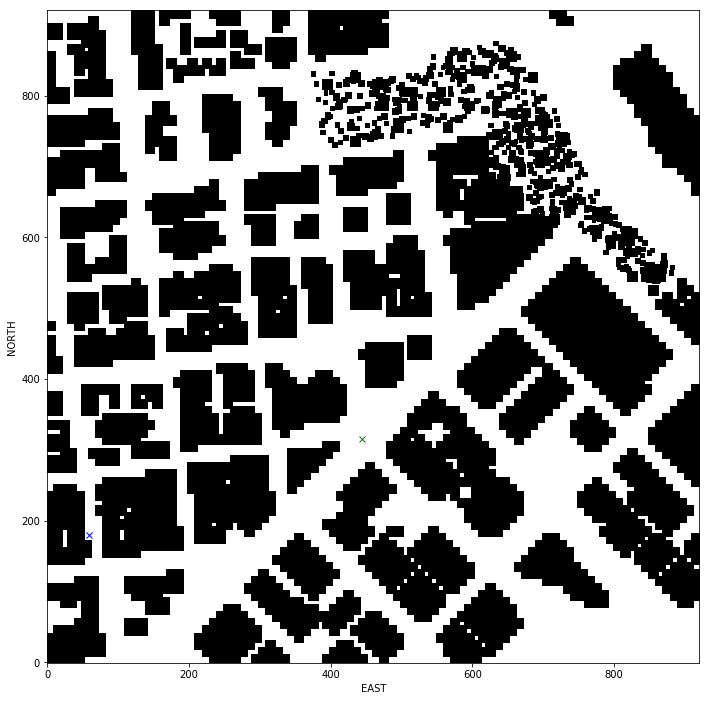

In [38]:
# equivalent to
plt.imshow(np.flip(grid, 0))

plt.imshow(grid, cmap='Greys', origin='lower')
# plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
    
plt.plot(start_ne[1], start_ne[0], 'gx')
plt.plot(goal_ne[1], goal_ne[0], 'bx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [39]:
print(start_ne, goal_ne)

(316, 444, 0) (180, 59, 0)


In [47]:
sampler = Sampler(data)
polygons = sampler._polygons
# Example: sampling 100 points and removing
# ones conflicting with obstacles.
margin = 50
# nodes = sampler.sample_in_margin(100, start_ne, goal_ne, margin)
nodes = sampler.sample(500)

# add the nodes to the sampler
# print(len(nodes))
# nodes.append(start_ne)
# nodes.append(goal_ne)

print(len(nodes))
nodes[0:2]

316


[(-245.256986456569, -286.9186746336944, 5.38013824293566),
 (-76.85480535376624, -99.86474046071487, 19.809957468203812)]

d=|b2-b1|/√(m2+1) 


In [48]:
import time
t0 = time.time()
g = create_graph(nodes, 10, polygons)
print('graph took {0} seconds to build'.format(time.time()-t0))

graph took 93.23652791976929 seconds to build


In [49]:
# start = list(g.nodes)[0]
start = closest_point(g, start_ne)
# goal = list(g.nodes)[k]
goal = closest_point(g, goal_ne)
# print(start, start_ne)

k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))

path, cost = a_star_graph(g, heuristic, start, goal)
print(len(path), path)

path_pairs = zip(path[:-1], path[1:])
# for (n1, n2) in path_pairs:
#     print(n1, n2)

225 297
Found a path.
6 [(269.4782120436079, 447.557728929399, 1.0912596572477917), (297.97913850532524, 394.9649788796704, 17.703355091016466), (258.2150493904075, 346.455022722939, 11.928973822302893), (255.04938311323184, 268.8817506740734, 18.768672366208328), (229.56723824343118, 267.1028834779281, 7.3328080788322065), (178.16189971109748, 173.45081842043635, 12.598256479457445)]


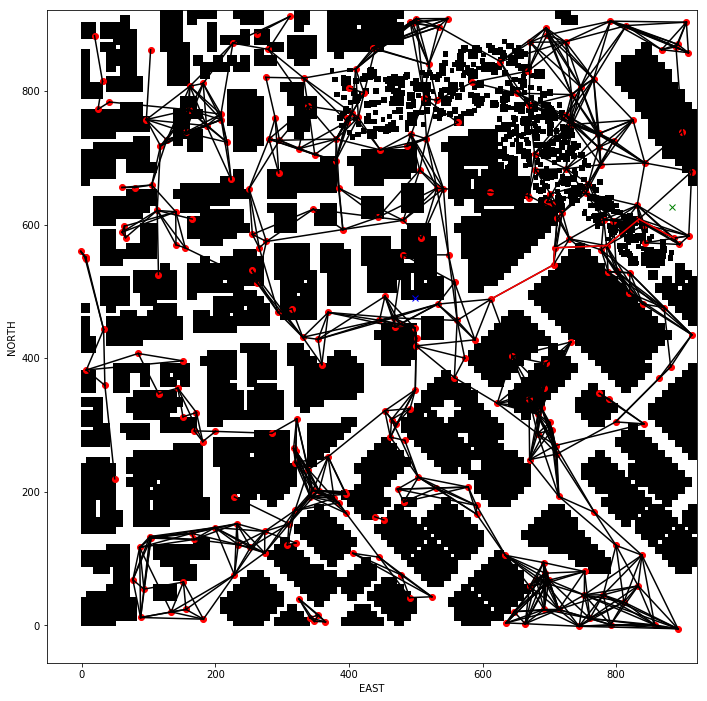

In [51]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# # # draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1]- emin, n1[0]- nmin, c='red')
    
# # # draw nodes
# for n1 in samples:
#     plt.scatter(n1[1], n1[0], c='blue')    
    
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'red')

plt.plot(start_ne[1] - emin, start_ne[0]- nmin, 'gx')
plt.plot(goal_ne[1] - emin, goal_ne[0]- nmin, 'bx')

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

In [38]:
import numpy.linalg as LA
from sklearn.neighbors import KDTree
import networkx as nx
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue


def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue
                
            if can_connect(n1, n2):
                g.add_edge(n1, n2, weight=1)
    return g

def closest_point(graph, current_point):
    """
    Compute the closest point in the `graph`
    to the `current_point`.
    """
    closest_point = None
    dist = 100000
    for p in graph.nodes:
        d = LA.norm(np.array(p) - np.array(current_point))
        if d < dist:
            closest_point = p
            dist = d
    return closest_point

In [41]:
def a_star_graph(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
#           print(current_node)
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
            
    return path[::-1], path_cost

In [102]:
_xmin = np.min(data[:, 0] - data[:, 3])
_xmax = np.max(data[:, 0] + data[:, 3])
num_samples = 100
_zmin = 0
# limit z-axis
_zmax = 20
margin = 100

def find_y_between_lines(num, m, b, b1, b2):
            '''
            Given a set of x, find random y that are inside parallel lines distance
            '''
            y_min = m*num+b1
            y_max = m*num+b2
            y= np.random.uniform(0,1, num.shape[0]) * (y_max - y_min) + y_min
            return y

min_x = np.min([start_ne[1]-margin, goal_ne[1]-margin])
max_x = np.max([start_ne[1]+margin, goal_ne[1]+margin])
print (min_x, max_x)


xvals = np.random.uniform(min_x, max_x, num_samples)
# xvals = np.random.uniform(_xmin, _xmax, num_samples)
# yvals = np.random.uniform(self._ymin, self._ymax, num_samples)

# find the slope between the start and end goal
diff = np.array(start)[0:2] - np.array(goal)[0:2]
slope = diff[0]/diff[1]
b = start[0] - start[1]*slope

# create 
b1 = b - margin*np.sqrt(slope**2+1)
b2 = b + margin*np.sqrt(slope**2+1)

yvals = np.apply_along_axis(find_y_between_lines, 0, xvals, slope, b, b1, b2)
zvals = np.random.uniform(_zmin, _zmax, num_samples)
samples = list(zip(yvals, xvals))


100 645
